In [19]:
import scipy.io.wavfile
import numpy as np
from math import floor
import scipy.signal as signal
from scipy.signal import lfilter, resample
from scipy.signal.windows import hann
from numpy.random import randn 

from scipy.fft import fft, rfft, ifft, irfft, fftfreq, rfftfreq
import matplotlib.pyplot as plt

SAMPLE_RATE_HZ = 48000
WINDOW_SIZE_SEC = 0.03 # 30ms
WINDOW_OVERLAP_PCT = 0.1 # 10%

In [20]:
"""
Split the original signal into overlapping blocks

x - a vector representing the time-series signal
w - array corresponding to weights of the window function
R - optional overlapping factor

Returns:

B - list of overlapping blocks
"""
def create_overlapping_blocks(x, w):
    n = len(x)
    nw = len(w)
    step = floor(nw * (1 - WINDOW_OVERLAP_PCT))
    nb = floor((n - nw) / step) + 1

    B = np.zeros((nb, nw))
    
    for i in range(nb):
        offset = i * step
        B[i, :] = w * x[offset : nw + offset]
        
    return B



In [21]:
# Plotting Utils

def plot_original_signal(x):
    fig1, ax = plt.subplots(figsize=(18, 5))
    plot_time(x, ax)

def plot_time(ys, ax):
    ts = np.array(range(len(ys))) / SAMPLE_RATE_HZ
        
    ax.plot(ts, ys)

def plot_scatter(ys, ax):
    # distance (in time) between subsequent windows
    window_granularity = (1 - WINDOW_OVERLAP_PCT) * WINDOW_SIZE_SEC

    ts = (np.array(range(len(ys))) * window_granularity + WINDOW_SIZE_SEC/2)
        
    ax.scatter(ts, ys)
    
def plot_line(xs, ys, ax):
    ax.plot(xs, ys)
    


In [22]:
# Implementation of algorithm from http://stackoverflow.com/a/22640362/6029703

import numpy as np
import pylab

def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y) - 1):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))


In [23]:

def compute_cepstrum(xs):
    return np.abs(ifft(np.log(np.absolute(fft(xs)))))
    

def compute_human_cepstrum(xs):
                
    cepstrum = compute_cepstrum(xs)
    quefrencies = np.array(range(len(xs)))/SAMPLE_RATE_HZ
    
    # Filter values that are not within human pitch range

    # highest frequency
    period_lb = 1/300.0
    # lowest frequency
    period_ub = 1/70
    
    cepstrum_filtered = []
    quefrencies_filtered = []
    for i, quefrency in enumerate(quefrencies):
        if quefrency < period_lb or quefrency > period_ub:
            continue
        
        quefrencies_filtered.append(quefrency)
        cepstrum_filtered.append(cepstrum[i])
        
    
    return (quefrencies_filtered, cepstrum_filtered)

"""
Finds the first index which looks like a peak. There might be multiple
peaks due to harmonics
"""
def find_freq_for_peak(quefrencies, cepstrum):

    lag = 5
    threshold = 10
    influence = 0.5
    result = thresholding_algo(cepstrum, lag, threshold, influence)
    
    # no peaks
    if max(result["signals"]) <= 0:
        return None
    
    return quefrencies[np.argmax(cepstrum)]

def compute_pitch(x, w, show_charts=True):
    B = create_overlapping_blocks(x, w)
    
    [nb, nw] = B.shape

    cepstrum_list = []
    quefrency_list = []
    
    indexes_to_plot = []
    
    pitch_values = [] # includes None
    for i in range(nb):
        xs = B[i, :]
        (quefrencies, cepstrum) = compute_human_cepstrum(xs)
        cepstrum_list.append(cepstrum)
        quefrency_list.append(quefrencies)
        
        pitch_period = find_freq_for_peak(quefrencies, cepstrum)

        pitch = None
        if pitch_period is not None:
            indexes_to_plot.append(i)
            pitch = 1/pitch_period
                    
        pitch_values.append(pitch)
            

    # Pitch distribution
    if show_charts:
        _, ax_pitch = plt.subplots(figsize=(18, 5))       
        
        plot_scatter(pitch_values, ax_pitch)

        samples_cnt = 10

        # Plot some samples
        samples_cnt = min(samples_cnt, len(indexes_to_plot))
        fig, axs = plt.subplots(samples_cnt, 2, figsize=(18, 3 * samples_cnt))
        fig.subplots_adjust(hspace=0.5)

        for j in range(samples_cnt):
            i = indexes_to_plot[j]
            xs = B[i, :]
            row_ax = axs[j]

            # original signal
            plot_time(xs, row_ax[0])
            row_ax[0].set_title(f'Signal {i}')

            plot_line(quefrency_list[i], cepstrum_list[i], row_ax[1])
            row_ax[1].set_title(f'Cepstrum {i}')

    valid_pitch_values = res = [pitch for pitch in pitch_values if pitch is not None]
    return np.median(valid_pitch_values)

Estimated pitch (Hz):  250.0


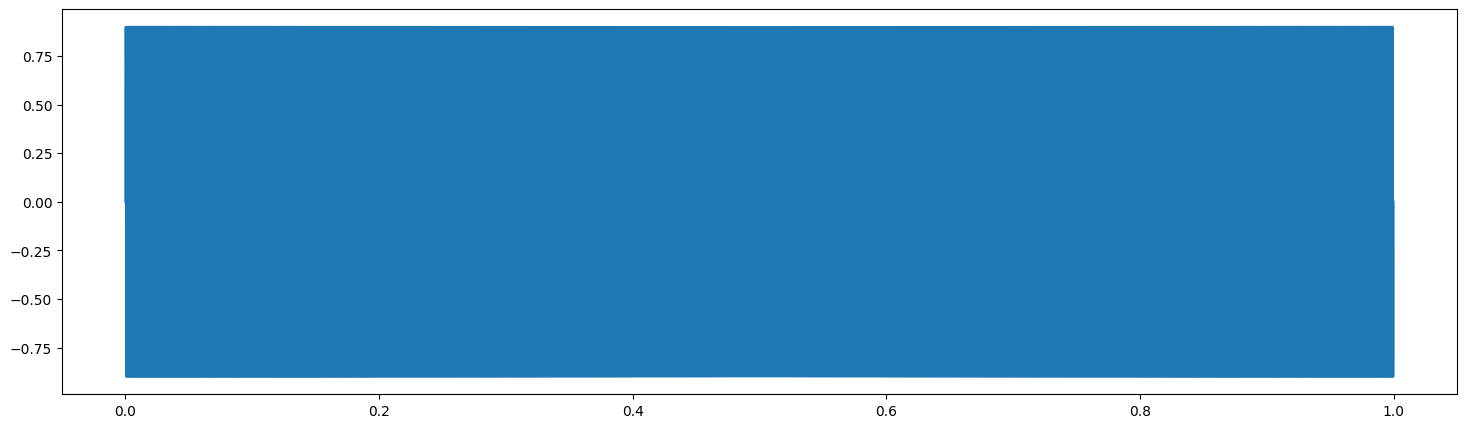

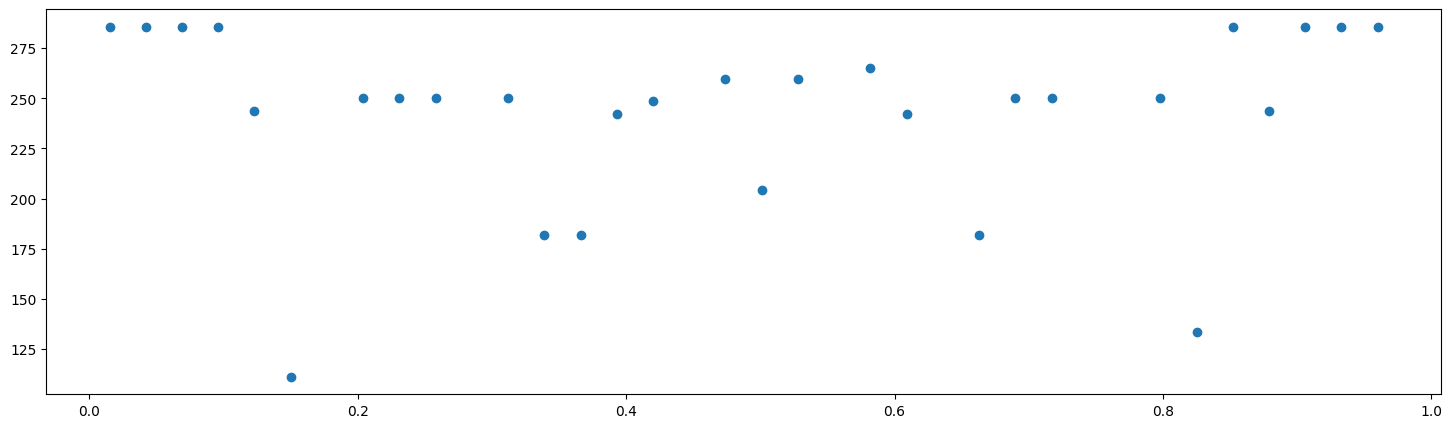

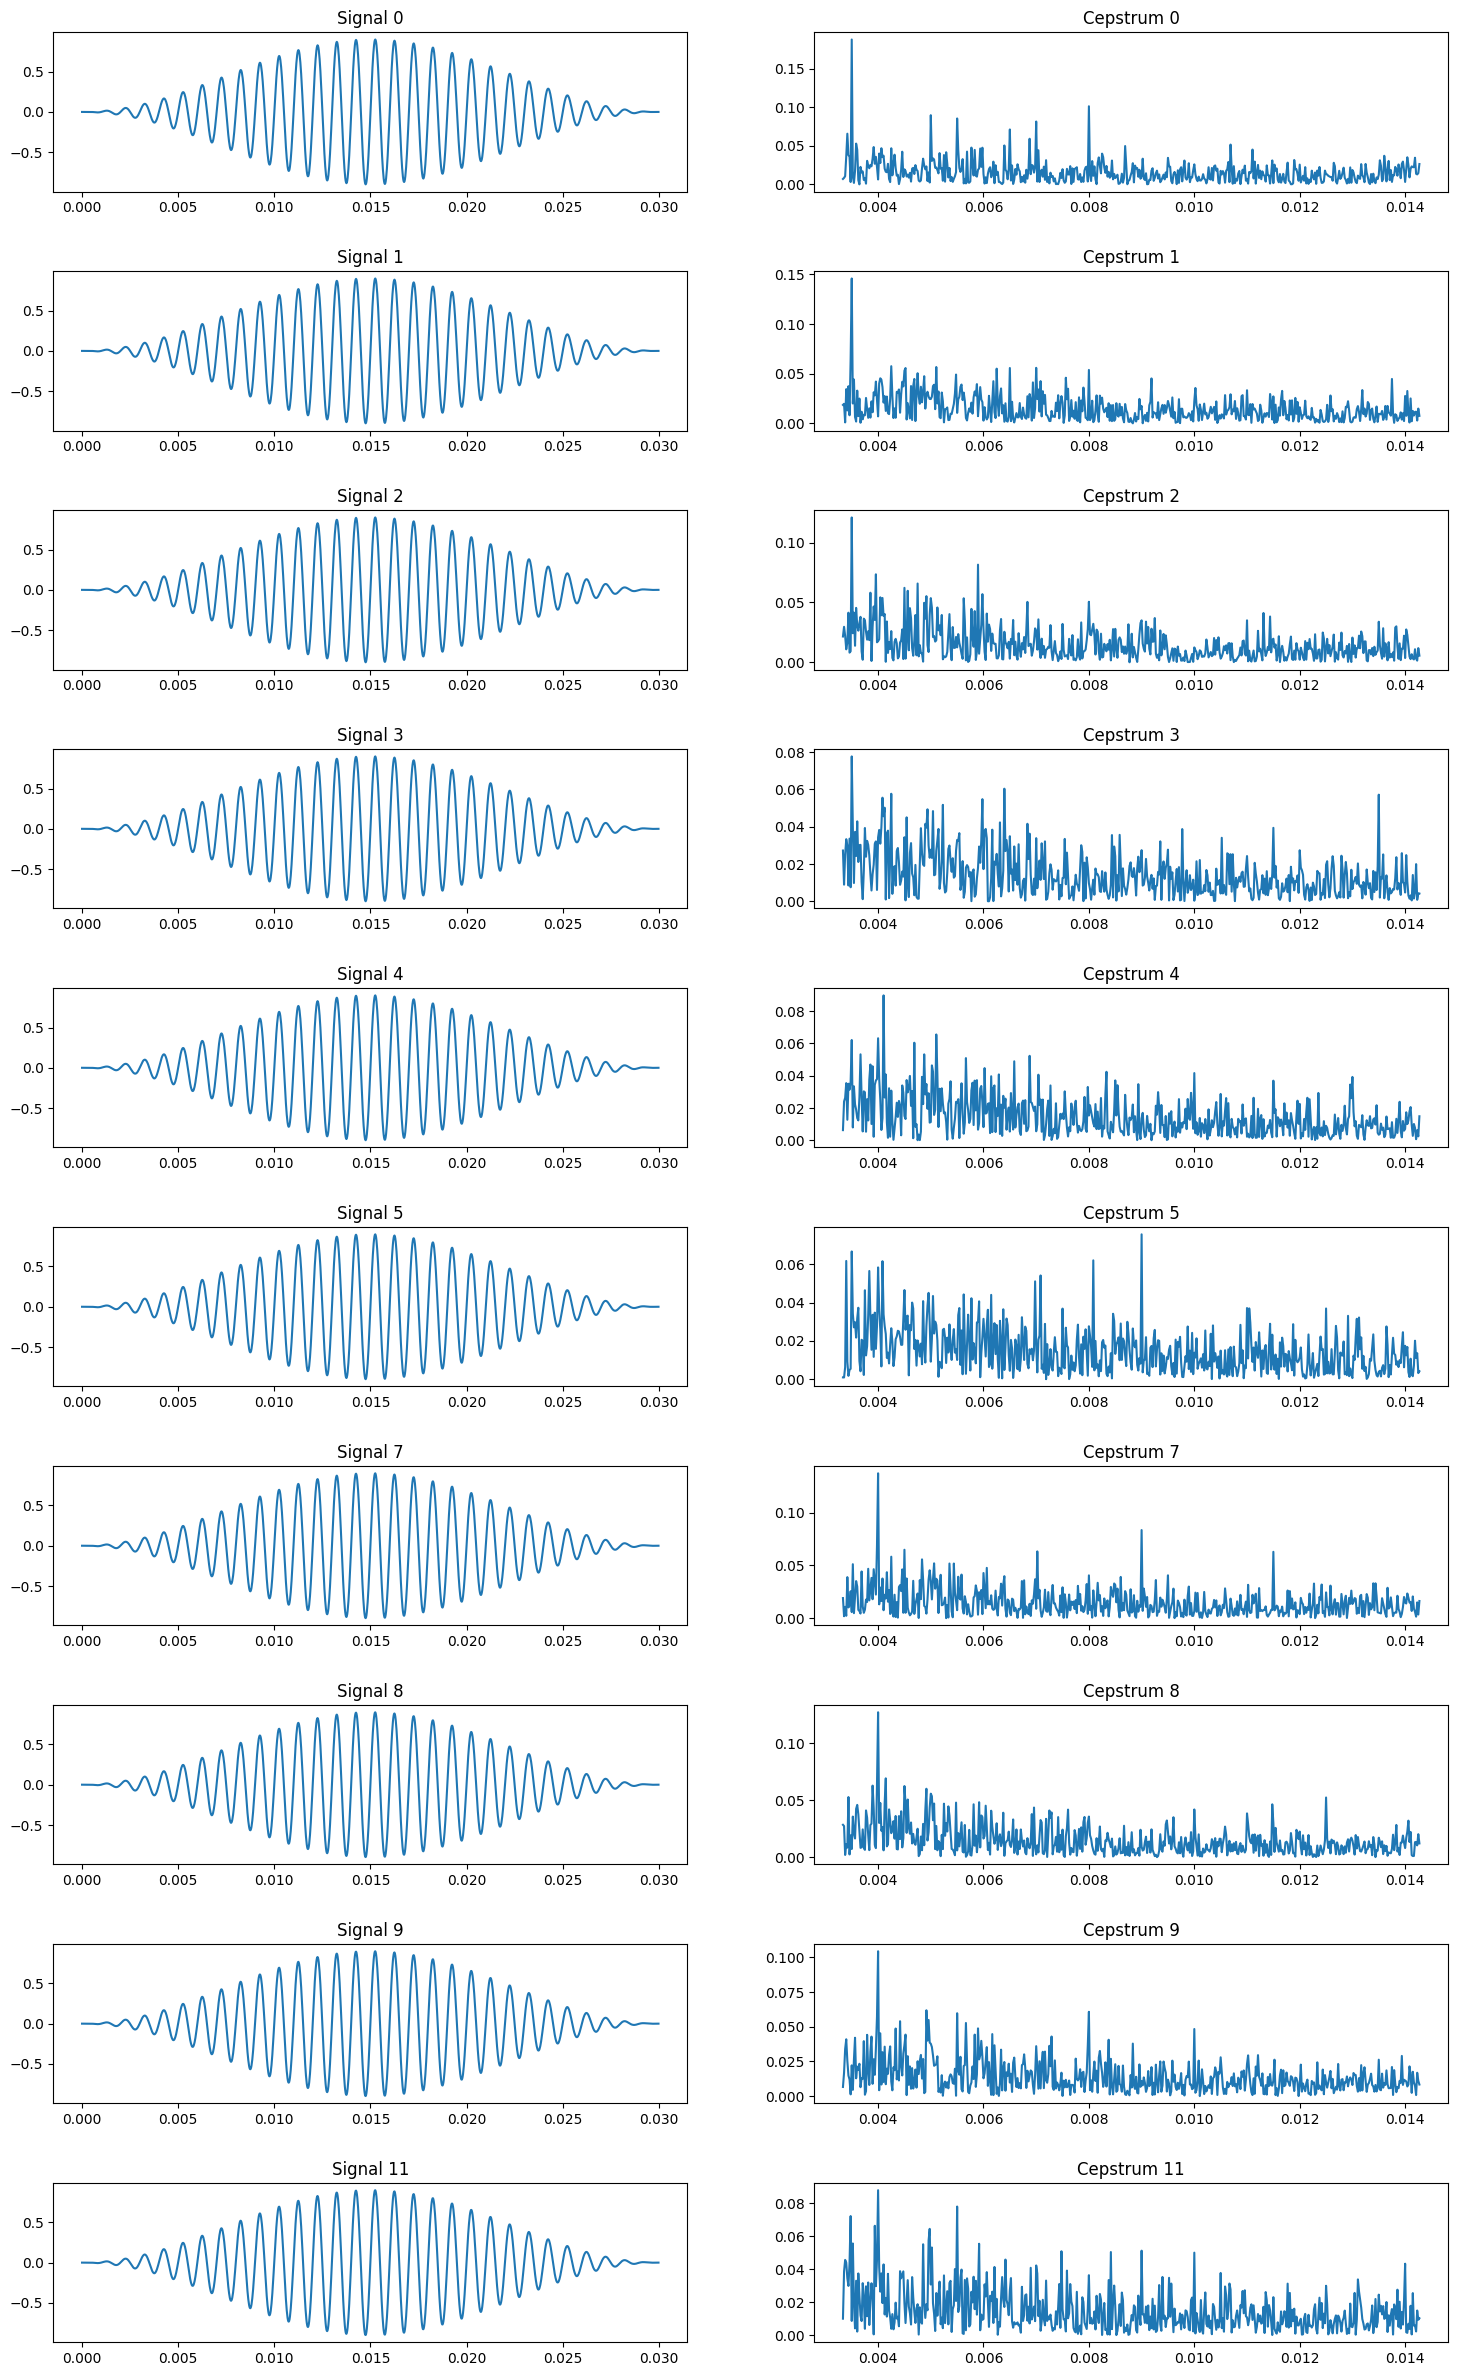

In [24]:
filename = None
filename = 'C:/Users/Asus/Desktop/programitas/UMAP prueba/Cluster/cluster_ref/sonido_ref_1000Hz.wav'

if filename is None:
    raise Exception('Please provide a valid path to a .wav file.')

[sample_rate, amplitudes] = scipy.io.wavfile.read(filename)
amplitudes = np.array(amplitudes)

# normalize
amplitudes = 0.9*amplitudes/max(abs(amplitudes)); 

# resampling
target_sample_rate = SAMPLE_RATE_HZ
target_size = int(len(amplitudes)*target_sample_rate/sample_rate)
amplitudes = resample(amplitudes, target_size) 

# 30ms Hann window
sym = False # periodic
w = hann(floor(WINDOW_SIZE_SEC*SAMPLE_RATE_HZ), sym) 

plot_original_signal(amplitudes)

# Compute Pitch
pitch = compute_pitch(amplitudes, w, show_charts=True)
print(f'Estimated pitch (Hz): ', pitch)